In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [3]:
!pip install --upgrade pymc

In [5]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

# Assuming the dataframe is already loaded as 'df'
df=pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')


# Step 1: Preprocess the data
# Convert categorical variables to numerical
df['person_home_ownership'] = pd.Categorical(df['person_home_ownership']).codes
df['loan_intent'] = pd.Categorical(df['loan_intent']).codes
df['loan_grade'] = pd.Categorical(df['loan_grade']).codes
df['cb_person_default_on_file'] = pd.Categorical(df['cb_person_default_on_file']).codes

# Normalize numerical variables
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
for col in numerical_cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

# Prepare X (features) and y (target)
X = df[['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 
        'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
        'cb_person_default_on_file', 'cb_person_cred_hist_length']]
y = df['loan_status']

In [7]:
X.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,1.566187,-0.765761,3,-1.187190,1,1,-0.578301,0.267613,0.117377,0,2.031781
1,-0.920049,-0.212126,2,0.328044,3,2,-0.937767,0.880525,-0.973233,0,-0.946481
2,0.240194,-0.929216,2,0.833122,4,0,-0.578301,-0.585849,0.553621,0,1.039027
3,0.405943,0.156964,3,2.348357,5,1,0.500097,0.142395,0.117377,0,-0.201915
4,-0.920049,-0.106672,3,-0.682112,3,0,-0.578301,-1.238303,-0.646050,0,-0.698292


In [8]:
# Step 2: Define the Bayesian model
with pm.Model() as loan_model:
    # Priors for unknown model parameters
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=10, shape=X.shape[1])
    
    # Expected value of outcome
    mu = intercept + pm.math.dot(X, betas)
    
    # Likelihood (sampling distribution) of observations
    y_obs = pm.Bernoulli('y_obs', logit_p=mu, observed=y)

# Step 3: Prior Predictive Analysis
with loan_model:
    prior_predictive = pm.sample_prior_predictive(samples=1000)

In [9]:
# Step 3: Inference
with loan_model:
    # Draw posterior samples
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Step 4: Analyze the results
summary = az.summary(trace, var_names=['intercept', 'betas'])
print(summary)

Output()

Output()

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -2.250  2.036  -4.356   -0.215      1.437    1.216       3.0   
betas[0]  -0.208  0.310  -0.518    0.135      0.219    0.185       3.0   
betas[1]   0.275  0.546  -0.331    0.821      0.385    0.326       3.0   
betas[2]  -0.182  0.526  -0.709    0.358      0.371    0.315       3.0   
betas[3]   0.040  0.118  -0.096    0.157      0.083    0.070       3.0   
betas[4]  -0.297  0.167  -0.464   -0.119      0.118    0.100       3.0   
betas[5]   0.949  0.252   0.698    1.244      0.177    0.149       3.0   
betas[6]  -0.446  0.200  -0.644   -0.204      0.140    0.119       3.0   
betas[7]   0.418  0.560  -0.193    0.978      0.395    0.335       3.0   
betas[8]   0.856  0.268   0.589    1.162      0.189    0.159       3.0   
betas[9]   0.329  0.493  -0.206    0.821      0.347    0.294       3.0   
betas[10] -0.048  0.021  -0.087    0.002      0.003    0.002     189.0   

           ess_tail  r_hat  
intercep

Model accuracy: 0.87


In [10]:
# Step 5: Make predictions
with loan_model:
    post_pred = pm.sample_posterior_predictive(trace, var_names=['y_obs'])

# Calculate the mean predicted probability for each observation
y_pred = post_pred.posterior_predictive['y_obs'].mean(axis=(0, 1))

# You can use a threshold (e.g., 0.5) to classify loans as approved or not
y_pred_class = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = (y_pred_class == y).mean()
print(f"Model accuracy: {accuracy:.2f}")

Output()

Model accuracy: 0.87


In [11]:
# Step 6: Posterior Predictive Analysis
with loan_model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['y_obs'])

Output()

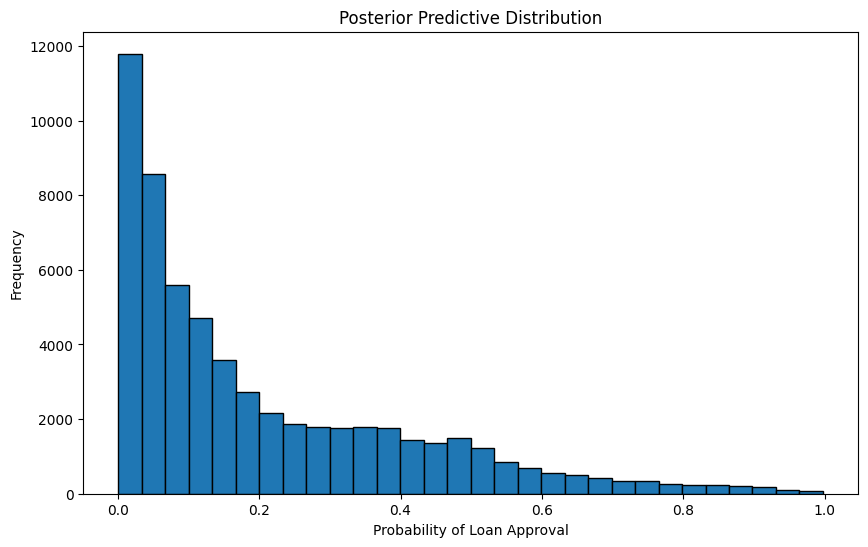

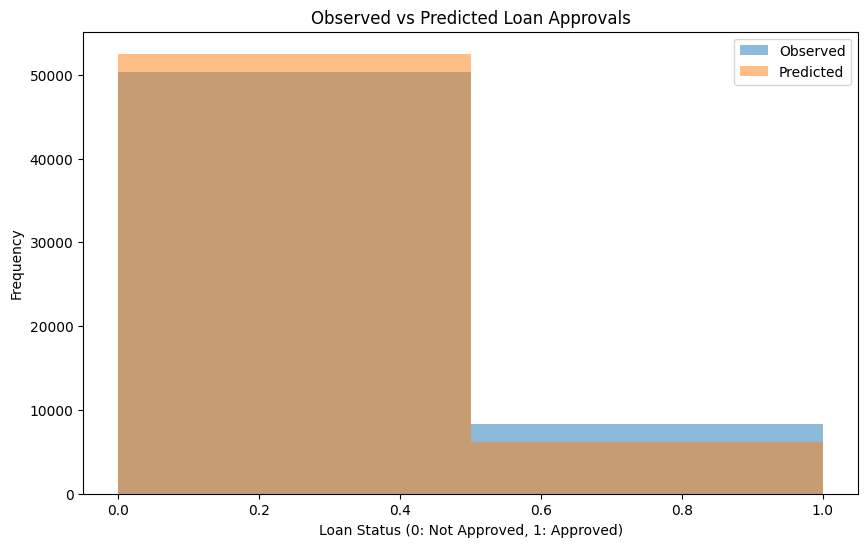

Model accuracy: 0.87


In [12]:
import matplotlib.pyplot as plt


# Visualize posterior predictive distribution
plt.figure(figsize=(10, 6))
plt.hist(posterior_predictive.posterior_predictive['y_obs'].mean(axis=(0, 1)), bins=30, edgecolor='black')
plt.title('Posterior Predictive Distribution')
plt.xlabel('Probability of Loan Approval')
plt.ylabel('Frequency')
plt.show()

# Compare observed data with posterior predictive
y_pred = posterior_predictive.posterior_predictive['y_obs'].mean(axis=(0, 1))
y_pred_class = (y_pred > 0.5).astype(int)

plt.figure(figsize=(10, 6))
plt.hist(y, bins=2, alpha=0.5, label='Observed')
plt.hist(y_pred_class, bins=2, alpha=0.5, label='Predicted')
plt.title('Observed vs Predicted Loan Approvals')
plt.xlabel('Loan Status (0: Not Approved, 1: Approved)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate and print accuracy
accuracy = (y_pred_class == y).mean()
print(f"Model accuracy: {accuracy:.2f}")

In [14]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,-0.756997,0.130139,3,-0.436116,2,5,2.824214,1.688216,2.187267,0,-0.940707
1,58646,-0.259712,0.841492,0,0.339400,4,2,0.134236,0.668423,-0.650126,1,-0.449567
2,58647,-0.259712,-0.897371,3,0.080894,5,4,-0.941755,2.161692,-0.322735,1,-0.940707
3,58648,0.900619,-0.370443,3,-0.177611,0,0,-0.403760,-0.583142,-0.213604,0,0.287143
4,58649,-0.259712,0.999571,0,0.856410,2,3,1.030895,1.873633,-0.104474,1,-0.449567


In [19]:
# Load the training data
# df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')  # Assuming your training data is in 'train.csv'

# Load the test data
df_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

# Function to preprocess data
def preprocess_data(df):
    df['person_home_ownership'] = pd.Categorical(df['person_home_ownership']).codes
    df['loan_intent'] = pd.Categorical(df['loan_intent']).codes
    df['loan_grade'] = pd.Categorical(df['loan_grade']).codes
    df['cb_person_default_on_file'] = pd.Categorical(df['cb_person_default_on_file']).codes

    numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
    for col in numerical_cols:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    
    return df

# Preprocess training and test data
# df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

# Prepare X (features) and y (target) for training data
# X_train = df_train[['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 
#                     'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
#                     'cb_person_default_on_file', 'cb_person_cred_hist_length']]
# y_train = df_train['loan_status']

# Prepare X for test data
X_test = df_test[['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 
                  'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
                  'cb_person_default_on_file', 'cb_person_cred_hist_length']]

# Step 2: Create a new model context for prediction
with loan_model:
    # Create a new set of observations with the same priors
    mu = intercept + pm.math.dot(df_test, betas)
    y_pred = pm.Bernoulli('y_pred', logit_p=mu, shape=X_test.shape[0])

    # Generate predictions
    posterior_predictive = pm.sample_posterior_predictive(
        trace, 
        var_names=['y_pred'], 
        predictions=True,
        random_seed=42
    )

# Step 3: Process the predictions
y_pred_samples = posterior_predictive.posterior_predictive['y_pred']
y_pred_mean = y_pred_samples.mean(dim=('chain', 'draw')).values

# If you want to classify based on a threshold (e.g., 0.5)
y_pred_class = (y_pred_mean > 0.5).astype(int)

# Calculate the mean predicted probability for each observation
y_pred = post_pred.posterior_predictive['y_obs'].mean(axis=(0, 1))

# You can use a threshold (e.g., 0.5) to classify loans as approved or not
y_pred_class = (y_pred > 0.5).astype(int)

# Calculate the mean predicted probability for each observation in test data
y_pred_proba = post_pred.posterior_predictive['y_obs'].mean(axis=(0, 1))

# Create submission dataframe
submission = pd.DataFrame({
    'id': df_test['id'],
    'loan_status': y_pred_proba
})

# Save submission file
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' has been created.")

ValueError: Variable name y_pred already exists.